# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Graphlab Create

In [14]:
#import graphlab
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
%matplotlib inline

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
sales = pd.read_csv('kc_house_data.csv', dtype= dtype_dict)
testing = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)
training = pd.read_csv('wk3_kc_house_train_data.csv', dtype=dtype_dict)
validation = pd.read_csv('wk3_kc_house_valid_data.csv', dtype=dtype_dict)

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [4]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
model_all = Lasso(alpha=5e2, normalize=True) # set parameters
model_all.fit(sales[all_features], sales['price']) # learn weights

Lasso(alpha=500.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Find what features had non-zero weight.

In [83]:
for x in zip(all_features, model_all.coef_): 
    print x

('bedrooms', 0.0)
('bedrooms_square', 0.0)
('bathrooms', 0.0)
('sqft_living', 134.43931395541438)
('sqft_living_sqrt', 0.0)
('sqft_lot', 0.0)
('sqft_lot_sqrt', 0.0)
('floors', 0.0)
('floors_square', 0.0)
('waterfront', 0.0)
('view', 24750.00458560952)
('condition', 0.0)
('grade', 61749.103090708129)
('sqft_above', 0.0)
('sqft_basement', 0.0)
('yr_built', -0.0)
('yr_renovated', 0.0)


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [8]:
#(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
#(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate
testing['sqft_living_sqrt'] = testing['sqft_living'].apply(sqrt)
testing['sqft_lot_sqrt'] = testing['sqft_lot'].apply(sqrt)
testing['bedrooms_square'] = testing['bedrooms']*testing['bedrooms']
testing['floors_square'] = testing['floors']*testing['floors']

training['sqft_living_sqrt'] = training['sqft_living'].apply(sqrt)
training['sqft_lot_sqrt'] = training['sqft_lot'].apply(sqrt)
training['bedrooms_square'] = training['bedrooms']*training['bedrooms']
training['floors_square'] = training['floors']*training['floors']

validation['sqft_living_sqrt'] = validation['sqft_living'].apply(sqrt)
validation['sqft_lot_sqrt'] = validation['sqft_lot'].apply(sqrt)
validation['bedrooms_square'] = validation['bedrooms']*validation['bedrooms']
validation['floors_square'] = validation['floors']*validation['floors']

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [20]:
l1_penalty_list = np.logspace(1,7,13) 

X_train = training[all_features]
y_train = training['price']
X_valid = validation[all_features ]
y_valid = validation['price']
X_test  = testing[all_features ]
y_test  = testing['price']

RSS_list = []
model_list =[]
for l1_penalty in l1_penalty_list :
    model = Lasso(alpha= l1_penalty, normalize=True) # set parameters
    model.fit(X_train, y_train)
    error = model.predict(X_valid) - y_valid
    RSS_list.append(np.dot(error, error) )
    model_list.append(model)
    
for x in zip(RSS_list, l1_penalty_list ):
    print x

(398213327300134.94, 10.0)
(399041900253346.81, 31.622776601683793)
(429791604072559.62, 100.0)
(463739831045121.06, 316.22776601683796)
(645898733633800.88, 1000.0)
(1222506859427162.8, 3162.2776601683795)
(1222506859427162.8, 10000.0)
(1222506859427162.8, 31622.776601683792)
(1222506859427162.8, 100000.0)
(1222506859427162.8, 316227.76601683791)
(1222506859427162.8, 1000000.0)
(1222506859427162.8, 3162277.6601683795)
(1222506859427162.8, 10000000.0)


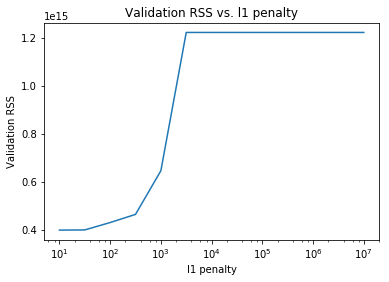

In [30]:
plt.plot( l1_penalty_list, RSS_list, '-' )
plt.xscale('log')
plt.xlabel('l1 penalty')
plt.ylabel('Validation RSS')
plt.title('Validation RSS vs. l1 penalty')

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [22]:
l1_penalty_list[np.argmin(RSS_list )]

10.0

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [31]:
model = model_list[np.argmin(RSS_list )]
np.count_nonzero(model.coef_) + np.count_nonzero(model.intercept_)

15

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [36]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [84]:
l1_penalty_values =  np.logspace(1, 4, num=20)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [85]:
RSS_list = []
model_list =[]
nonzero_coef =[]

for l1_penalty in l1_penalty_values :
    model = Lasso(alpha= l1_penalty, normalize=True) # set parameters
    model.fit(X_train, y_train)
    error = model.predict(X_valid) - y_valid
    RSS_list.append(np.dot(error, error) )
    model_list.append(model)
    nonzero_coef.append( np.count_nonzero(model.coef_) + np.count_nonzero(model.intercept_))

In [86]:
for x in zip( l1_penalty_values,nonzero_coef) :
    print x

(10.0, 15)
(14.384498882876629, 15)
(20.691380811147901, 15)
(29.763514416313178, 15)
(42.813323987193932, 13)
(61.584821106602639, 12)
(88.586679041008225, 11)
(127.42749857031335, 10)
(183.29807108324357, 7)
(263.66508987303581, 6)
(379.26901907322497, 6)
(545.55947811685144, 6)
(784.75997035146065, 5)
(1128.8378916846884, 3)
(1623.776739188721, 3)
(2335.7214690901214, 2)
(3359.8182862837812, 1)
(4832.9302385717519, 1)
(6951.9279617756056, 1)
(10000.0, 1)


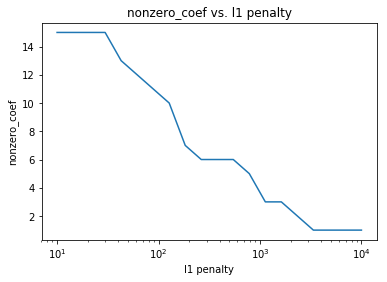

In [87]:
plt.plot( l1_penalty_values, nonzero_coef, '-' )
plt.xscale('log')
plt.xlabel('l1 penalty')
plt.ylabel('nonzero_coef')
plt.title('nonzero_coef vs. l1 penalty')

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [88]:
l1_penalty_min = 127.42749857031335
l1_penalty_max = 263.66508987303581

***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [89]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,100)
l1_penalty_values 

array([ 127.42749857,  128.80363586,  130.17977314,  131.55591043,
        132.93204771,  134.308185  ,  135.68432229,  137.06045957,
        138.43659686,  139.81273414,  141.18887143,  142.56500872,
        143.941146  ,  145.31728329,  146.69342057,  148.06955786,
        149.44569514,  150.82183243,  152.19796972,  153.574107  ,
        154.95024429,  156.32638157,  157.70251886,  159.07865615,
        160.45479343,  161.83093072,  163.207068  ,  164.58320529,
        165.95934258,  167.33547986,  168.71161715,  170.08775443,
        171.46389172,  172.840029  ,  174.21616629,  175.59230358,
        176.96844086,  178.34457815,  179.72071543,  181.09685272,
        182.47299001,  183.84912729,  185.22526458,  186.60140186,
        187.97753915,  189.35367644,  190.72981372,  192.10595101,
        193.48208829,  194.85822558,  196.23436286,  197.61050015,
        198.98663744,  200.36277472,  201.73891201,  203.11504929,
        204.49118658,  205.86732387,  207.24346115,  208.61959

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [90]:
RSS_list = []
model_list =[]
nonzero_coef =[]

for l1_penalty in l1_penalty_values :
    model = Lasso(alpha= l1_penalty, normalize=True) # set parameters
    model.fit(X_train, y_train)
    error = model.predict(X_valid) - y_valid
    RSS_list.append(np.dot(error, error) )
    model_list.append(model)
    nonzero_coef.append( np.count_nonzero(model.coef_) + np.count_nonzero(model.intercept_))

In [91]:
nonzero_coef

[10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

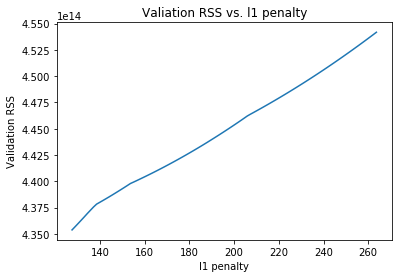

In [92]:
plt.plot( l1_penalty_values, RSS_list, '-' )
plt.xlabel('l1 penalty')
plt.ylabel('Validation RSS')
plt.title('Valiation RSS vs. l1 penalty')

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [94]:
nonzero_coef[20]

7

In [93]:
for x in zip(all_features, model_list[20].coef_  ):
    print x

('bedrooms', -0.0)
('bedrooms_square', -0.0)
('bathrooms', 10854.443479272539)
('sqft_living', 163.30354659048507)
('sqft_living_sqrt', 0.0)
('sqft_lot', -0.0)
('sqft_lot_sqrt', -0.0)
('floors', 0.0)
('floors_square', 0.0)
('waterfront', 507375.04119386961)
('view', 41979.794839556045)
('condition', 0.0)
('grade', 116374.65694207841)
('sqft_above', 0.0)
('sqft_basement', 0.0)
('yr_built', -2620.6721389082932)
('yr_renovated', 0.0)
